In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image, ImageFile

from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from torch.cuda.amp import autocast

In [56]:
# Load the pre-trained ResNet model
model = models.resnet18(pretrained=True)

In [57]:
# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Change the output layer to 1 output

In [58]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(torch.cuda.is_available())

True


In [59]:
# Define a custom dataset
class WildfireDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = list(directory.glob('*.jpg')) 

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [60]:
# Define transformations for the input data
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data_path = "../data/train"

ImageFile.LOAD_TRUNCATED_IMAGES = True

def tolerant_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    except IOError as e:
        print(f"Could not load image {path}: {e}, skipping.")

# Replace the default loader with the tolerant loader
datasets.ImageFolder.loader = tolerant_loader


# Create the dataset using ImageFolder
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)

# Create a DataLoader to feed data to your model
batch = 64
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=4, pin_memory=True)

In [61]:
validation_path = "../data/valid"
validation_dataset = datasets.ImageFolder(root=validation_path, transform=transform)
valid_loader = DataLoader(validation_dataset, batch_size=batch, shuffle=False, num_workers=4, pin_memory=True)

In [62]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Training loop (simplified for illustration)
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # Use tqdm to show the progress bar for training
    pbar = tqdm(
        enumerate(train_loader), 
        total=len(train_loader), 
        desc=f"Epoch {epoch+1}/{num_epochs}", 
        position=0, 
        leave=True
    )
    
    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Update tqdm bar to show the running loss
        pbar.set_postfix({'loss': running_loss/(i+1)})

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
    
    # Evaluate model on validation set
    model.eval()
    predictions = []
    labels_list = []
    
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())  

    accuracy = accuracy_score(labels_list, predictions)
    print(f"Validation Accuracy: {accuracy:.4f}")
    
    # Save model checkpoint at the end of each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': running_loss,
    }, f'model_epoch_{epoch}.pth')

print("Training complete.")

Epoch 1/100:   4%|▍         | 21/473 [00:01<00:41, 10.87it/s, loss=0.569]


KeyboardInterrupt: 

In [63]:
# Example transformation, adjust according to your needs
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to load and transform an image
def process_image(image_path):
    image = Image.open(image_path)
    image = transform(image).float()
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

test_data_path = "../data/test"
test_set = datasets.ImageFolder(test_data_path, transform=transform)
test_loader = DataLoader(test_set, batch_size=batch, shuffle=False, num_workers=4, pin_memory=True)

In [64]:
for i in range(1, 60):
    checkpoint = torch.load(f"model_epoch_{i}.pth")
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    model.to(device)
    predictions = []
    labels = []
    
    with torch.no_grad():
        with autocast():
            for inputs, actual in test_loader:  # Labels are not needed
                inputs = inputs.to(device)
                outputs = model(inputs)

                # Assuming a single-class classification, get the predicted classes
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
                labels.extend(actual.cpu().numpy())  
#                 print("i")

    accuracy = accuracy_score(labels, predictions)
    print(f"Model-{i} Accuracy: {accuracy:.4f}")

    
# At this point, 'predictions' contains the predicted class indices for all test images
    
    

KeyboardInterrupt: 

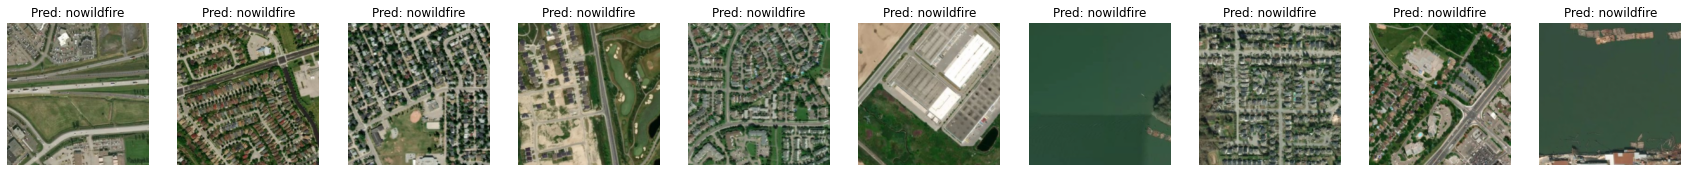

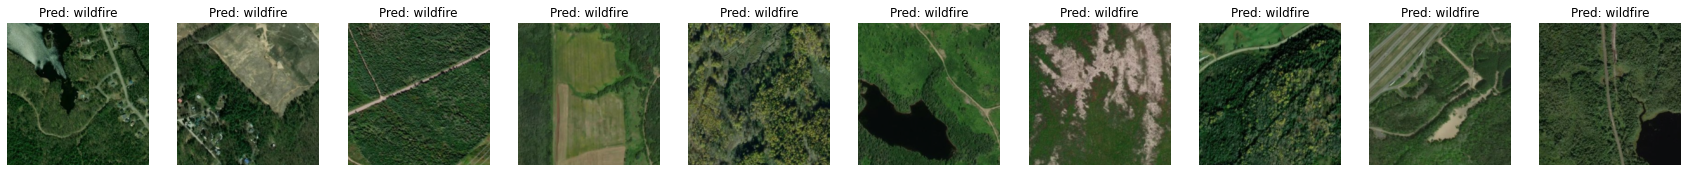

In [65]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Loading the dataset
dataset = datasets.ImageFolder(root='../data/test', transform=transform)

classes = dataset.classes

# Sample 10 random indices for each class
indices = {class_name: random.sample([i for i, (_, class_idx) in enumerate(dataset.samples) if dataset.classes[class_idx] == class_name], 10) for class_name in classes}

# Create a subset for each class
subsets = {class_name: torch.utils.data.Subset(dataset, indices) for class_name, indices in indices.items()}

batch_size = 10  # As we have 10 images per class
dataloaders = {class_name: DataLoader(subset, batch_size=batch_size, shuffle=False) for class_name, subset in subsets.items()}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint = torch.load(f"model_epoch_1.pth")
model.load_state_dict(checkpoint["model_state_dict"])

model.to(device)
model.eval()

for class_name, dataloader in dataloaders.items():
    images, _ = next(iter(dataloader))
    images = images.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu()
    
    fig, axes = plt.subplots(1, 10, figsize=(30, 3))
    for i, (image, pred) in enumerate(zip(images, preds)):
        ax = axes[i]
        img = image.numpy().transpose((1, 2, 0))
        img = std * img + mean  # unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Pred: {classes[pred]}')
        ax.axis('off')

    plt.show()


In [66]:
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = Path(img_dir)
        self.transform = transform
        self.img_paths = list(self.img_dir.glob('*.png')) 

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        filename = img_path.name 
        image = read_image(str(img_path)) 
        if self.transform:
            image = transforms.ToPILImage()(image)
            image = self.transform(image)
        return image, filename 

single = CustomImageDataset("../data/field", transform=transform)
single_loader = DataLoader(single, shuffle=True, batch_size=1, pin_memory=True)
print(len(single))

1107


In [67]:
model.eval()  # set the model to evaluation mode
predictions = []

with torch.no_grad():
    for images, filenames in single_loader:  # single_loader now also yields filenames
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(zip(preds.cpu().numpy(), filenames))

In [68]:
print(predictions[:10])

[(1, '-120.51104388533815,39.01110625849579.png'), (1, '-120.78848388533811,39.44406625849577.png'), (1, '-120.33764388533818,39.22758625849578.png'), (1, '-120.8578438853381,39.57936625849577.png'), (1, '-120.44168388533816,39.606426258495766.png'), (1, '-120.33764388533818,39.173466258495786.png'), (1, '-121.34336388533802,39.25464625849578.png'), (1, '-120.58040388533814,39.01110625849579.png'), (1, '-121.34336388533802,39.66054625849576.png'), (1, '-120.61508388533814,39.25464625849578.png')]


In [73]:
pred_dict = {}
# print([i for (i, _) in predictions])
dataset = datasets.ImageFolder(root='../data/test', transform=transform)
for pred, filename in predictions:
    pred_class = dataset.classes[pred]
#     print(f"{filename}:{pred_class}")
    if pred_dict.get(pred_class) is not None:
        pred_dict[pred_class].append(filename) 
    else:
        pred_dict[pred_class] = [filename]

print(pred_dict['wildfire'])
# print(pred_dict['nowildfire'])

['-120.51104388533815,39.01110625849579.png', '-120.78848388533811,39.44406625849577.png', '-120.33764388533818,39.22758625849578.png', '-120.8578438853381,39.57936625849577.png', '-120.44168388533816,39.606426258495766.png', '-120.33764388533818,39.173466258495786.png', '-121.34336388533802,39.25464625849578.png', '-120.58040388533814,39.01110625849579.png', '-121.34336388533802,39.66054625849576.png', '-120.61508388533814,39.25464625849578.png', '-120.8578438853381,39.36288625849578.png', '-120.8578438853381,39.52524625849577.png', '-121.447403885338,39.389946258495776.png', '-120.8925238853381,39.47112625849577.png', '-120.54572388533815,39.55230625849577.png', '-121.13528388533805,39.06522625849579.png', '-120.51104388533815,39.14640625849579.png', '-120.30296388533819,38.984046258495795.png', '-120.44168388533816,39.49818625849577.png', '-120.8925238853381,38.984046258495795.png', '-121.20464388533804,38.984046258495795.png', '-121.16996388533805,39.33582625849578.png', '-120.5110